### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
import subjects

### Visualize running behavior for all rats and tally lap #s by hand

In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [16]:
sess.paradigm.to_dataframe()

,start,stop,label,duration
0,0,7288,pre,7288
1,7302,10683,maze,3381
2,10685,43156,post,32471
3,10685,28685,sd,18000
4,28685,43156,rs,14471
5,43157,47043,re-maze,3886


In [5]:
t_bw, t_sd = [], []
for sess in subjects.remaze_sess()[1:]:
    t_bw.append((sess.paradigm['re-maze'].starts[0] - sess.paradigm['maze'].stops[0])/60/60)

t_bw

[9.017222222222221,
 9.014444444444445,
 8.937222222222223,
 9.333888888888888,
 9.003333333333334,
 9.059722222222224,
 9.022777777777778,
 9.020555555555555]

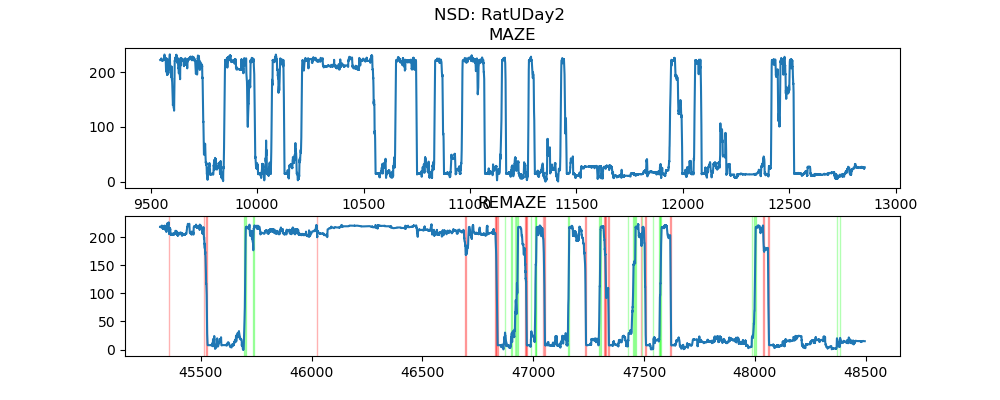

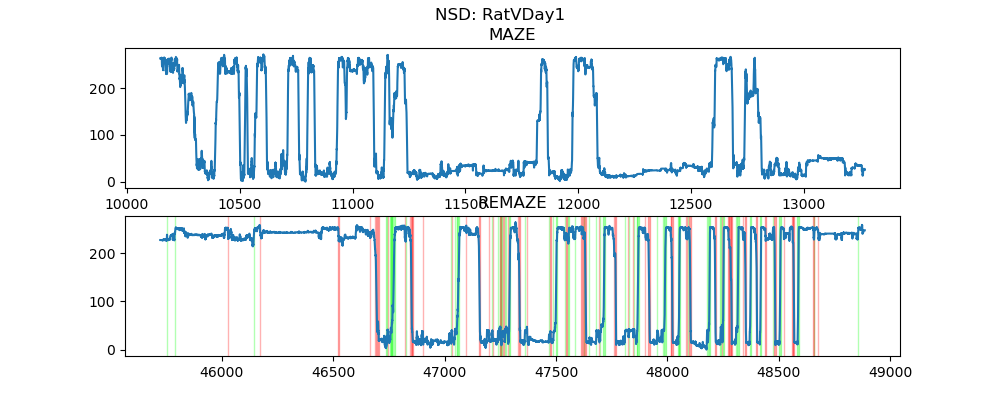

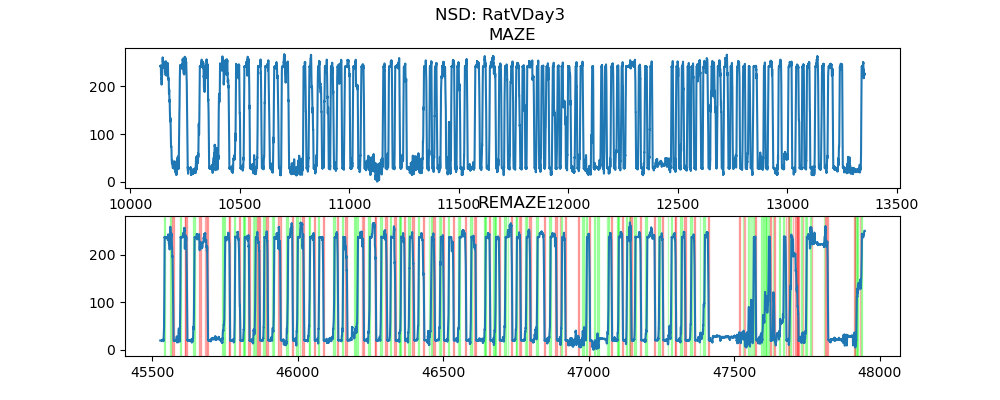

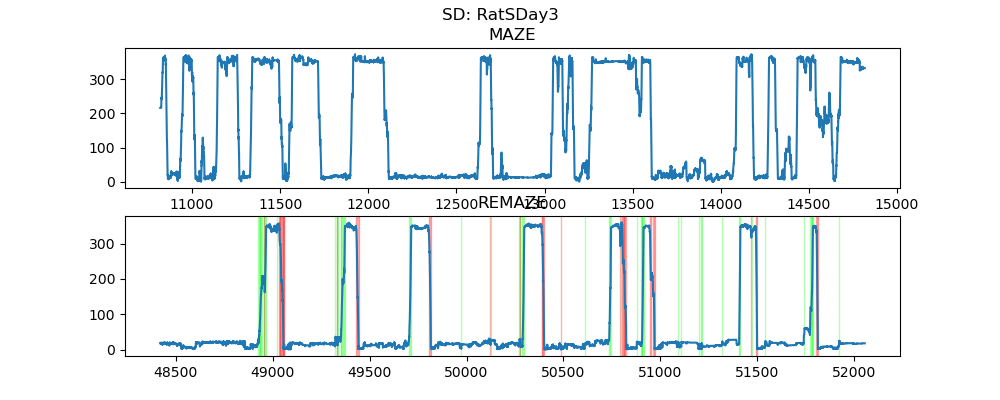

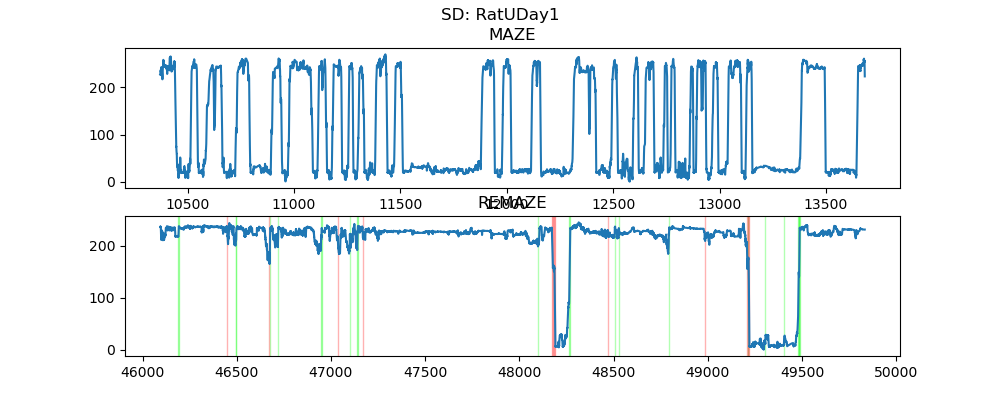

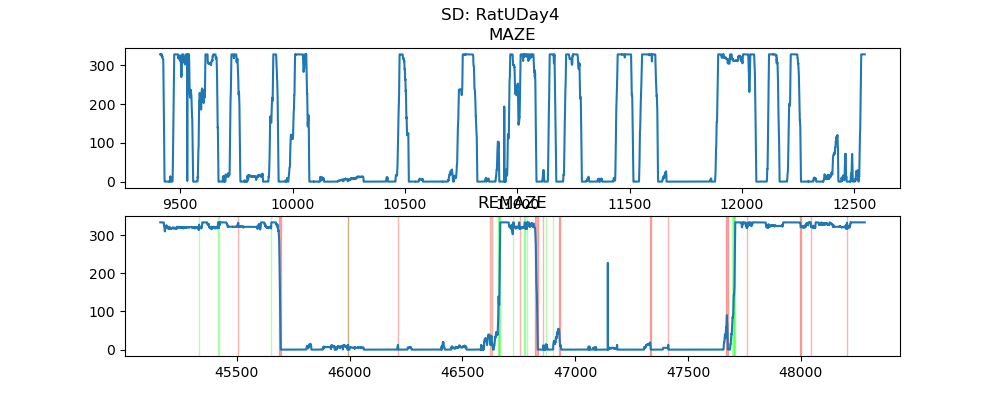

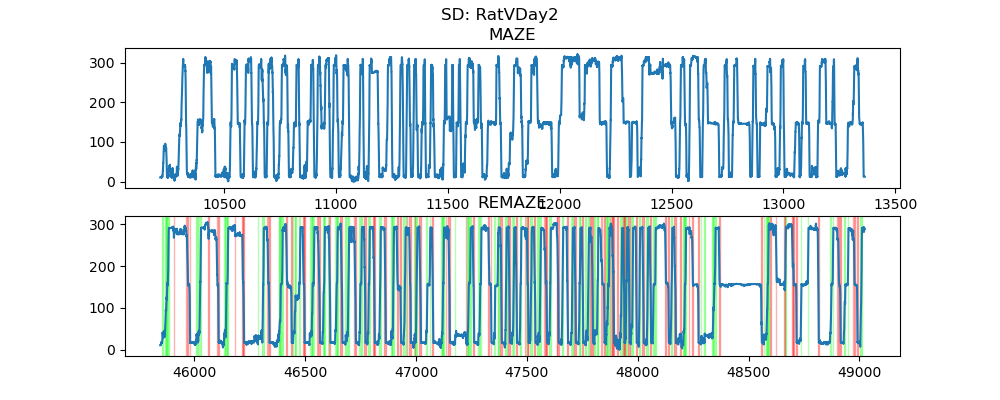

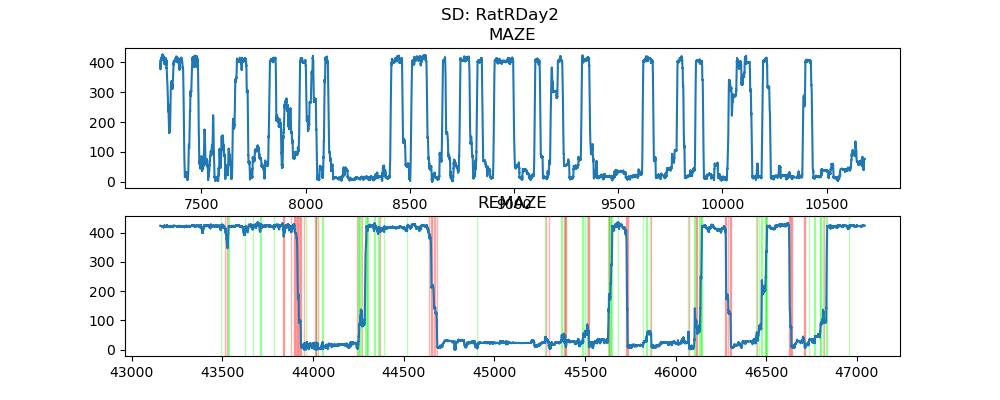

In [3]:
%matplotlib widget
for sess in subjects.remaze_sess()[1:]:
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    fig.suptitle(f"{sess.tag}: {sess.name}")
    ax[0].plot(sess.maze.time, sess.maze.x)
    ax[0].set_title("MAZE")
    ax[1].plot(sess.remaze.time, sess.remaze.x)
    ax[1].set_title("REMAZE")
    for col, dir in zip([[0, 1, 0, 0.3], [1, 0, 0, 0.3]], ["up", "down"]):
        for start, stop in zip(sess.remaze_run[dir].starts, sess.remaze_run[dir].stops):
            ax[1].axvspan(start, stop, color=col)

### Placefields and population vector correlation MAZE vs REMAZE

In [442]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=5)

tc_all = []
for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")

    # ---- Run direction sepearted-------
    tc_maze, tc_remaze = [], []
    for direction in ["up", "down"]:
        maze_run = sess.maze_run[direction]
        pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run, **kw)
        tc_maze.append(pfmaze.resample_1D(50).tuning_curves)

        remaze_run = sess.remaze_run[direction]
        pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run, **kw)
        tc_remaze.append(pfremaze.resample_1D(50).tuning_curves)

    tc_comb = np.hstack((np.vstack(tc_maze), np.vstack(tc_remaze)))

    # ---- Overall----
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    # tc_maze = pfmaze.resample(50).tuning_curves

    # pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    # tc_remaze = pfremaze.resample(50).tuning_curves

    # tc_comb = np.hstack((tc_maze, tc_remaze))

    tc_comb_df = pd.DataFrame(tc_comb)
    tc_comb_df["session"] = s
    tc_comb_df["grp"] = sess.tag
    tc_all.append(tc_comb_df)

tc_all = pd.concat(tc_all, ignore_index=True)

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignore

### Plot individual PFs and PV correlations across MAZE-reMAZE

/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(
/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/utils/mathutil.py:67: RuntimeWarning: invalid value encountered in divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


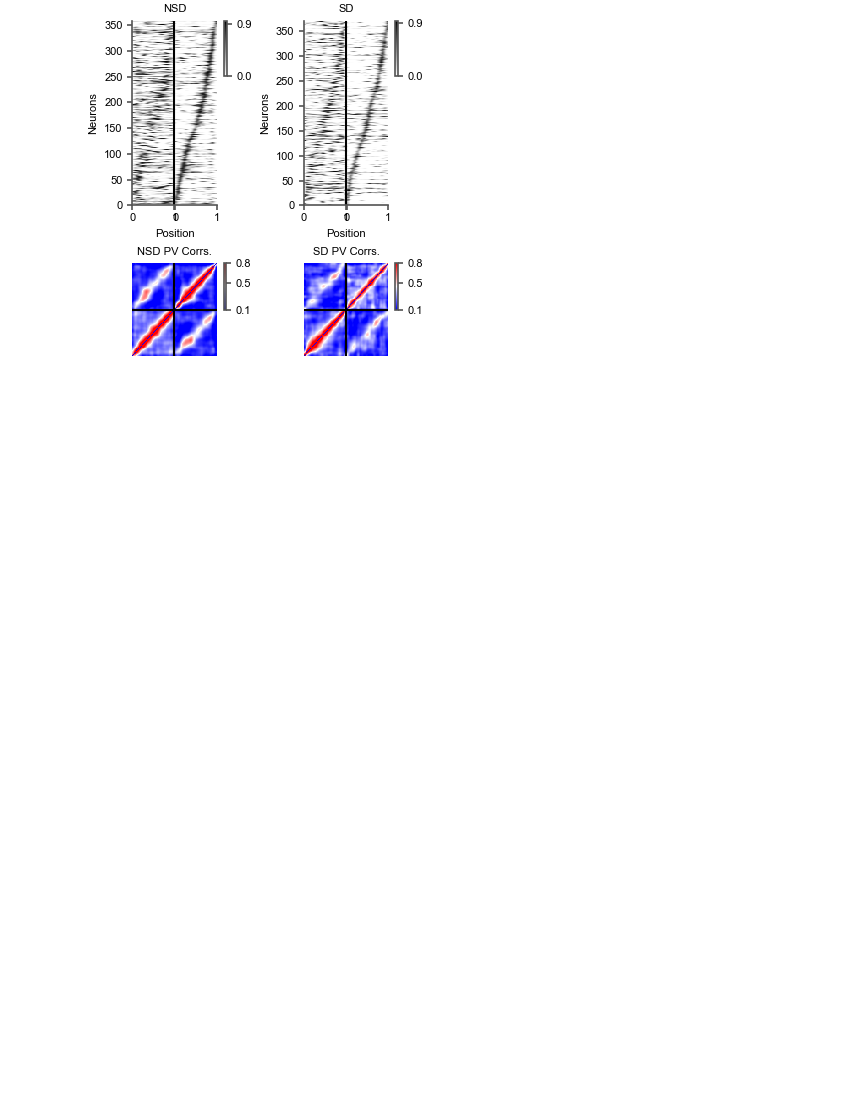

In [63]:
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

fig = plotting.Fig(11, 8)

exclude_nan = True
sort_by = "reMAZE"
assert sort_by in ["MAZE", "reMAZE"]
corr_all, tc_new_all = [], []
for g, grp in enumerate(["NSD", "SD"]):

    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp].drop(columns=["session", "grp"]).to_numpy()
    assert (nbins_per_sesh := int(tc_grp.shape[1]/2)) == tc_grp.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"
    
    # Scale each row to its peak firing rate
    tc_new = np.zeros_like(tc_grp)
    tc_new[:, :nbins_per_sesh] = min_max_scaler(tc_grp[:, :nbins_per_sesh], axis=1)
    tc_new[:, nbins_per_sesh:] = min_max_scaler(tc_grp[:, nbins_per_sesh:], axis=1)
    # tc_new =  min_max_scaler(tc_grp,axis=-1)

    # Sort by MAZE or reMAZE
    if sort_by == "MAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, :nbins_per_sesh], axis=1))
    elif sort_by == "reMAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, nbins_per_sesh:], axis=1))
    tc_new = gaussian_filter1d(tc_new, sigma=1.5, axis=1)
    tc_new_df = pd.DataFrame(tc_new[sort_ind])
    tc_new_df["session"] = tc_all[tc_all.grp == grp].session.values[sort_ind]
    tc_new_df["grp"] = grp
    tc_new_all.append(tc_new_df)
    # print(tc_new.shape)

    # Plot place fields
    ax = fig.subplot(fig.gs[:2, g + 1])
    ax.set_title(grp)
    pf_plot = tc_new[sort_ind, :]
    pf_plot = pf_plot[~np.any(np.isnan(pf_plot), axis=1)] if exclude_nan else pf_plot
    pf_im = ax.pcolormesh(pf_plot, cmap="binary", rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.set_xticks([0, nbins_per_sesh, nbins_per_sesh + 1, nbins_per_sesh * 2], [0, 1, 0, 1])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Position")
    pf_cb = plt.colorbar(pf_im, anchor=(1, 1), shrink=0.3, ticks=[0, 0.9])

    # Plot PV correlations
    ax = fig.subplot(fig.gs[2, g + 1])
    ax.set_title(f"{grp} PV Corrs.")
    corr = gaussian_filter(np.corrcoef(tc_grp.T), 1)
    # corr = np.corrcoef(tc_grp.T)
    np.fill_diagonal(corr, 0)
    corr_all.append(corr)
    corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.axhline(nbins_per_sesh, color="k")
    ax.axis("off")
    corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])


# fig.savefig(subjects.figpath_sd / f"maze_remaze_pf_corrs_{sort_by}sorted")

### Quantify PV correlations

Text(0.5, 1.0, 'nbins=2162')

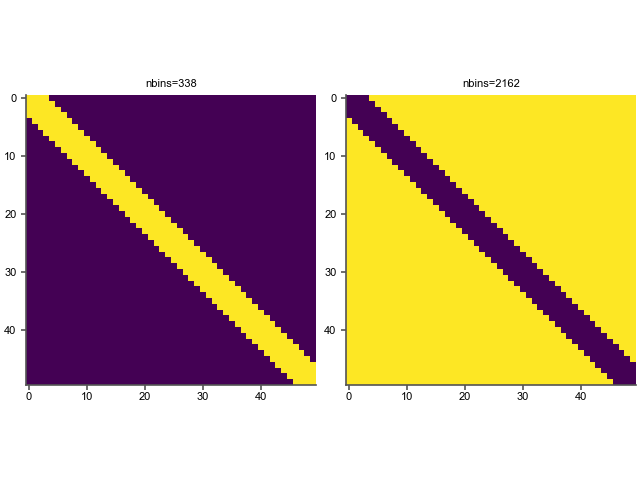

In [104]:
# Sanity check for plotting and calculating diagonal and off-diagonal values
t = np.ones((50, 50))
noffset = 3
_, ax = plt.subplots(1, 2)
t_diag = np.tril(np.triu(t, -noffset), noffset)
ax[0].imshow(t_diag)
ax[0].set_title(f"nbins={np.sum(t_diag.reshape(-1) != 0)}")
t_off = np.triu(t, noffset + 1) + np.tril(t, -noffset - 1)
ax[1].imshow(t_off)
ax[1].set_title(f"nbins={np.sum(t_off.reshape(-1) != 0)}")

NSD Off diagonal corrs = [0.3306325048041607, 0.1829719575199008, 0.1829719575199008, 0.2185389960628285]
NSD On diagonal corrs = [0.8258941732053255, 0.44568222535986035, 0.44568222535986035, 0.7697744124961617]
SD Off diagonal corrs = [0.2961950827340916, 0.19393287588969366, 0.19393287588969366, 0.2795274399590834]
SD On diagonal corrs = [0.8044136006157208, 0.39512673000081944, 0.39512673000081944, 0.680816789541048]


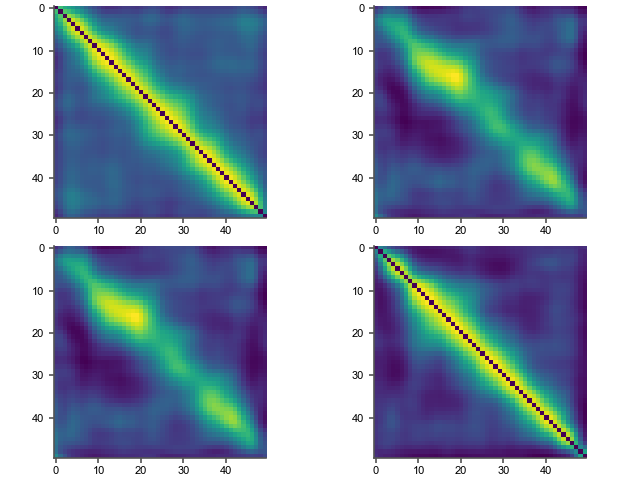

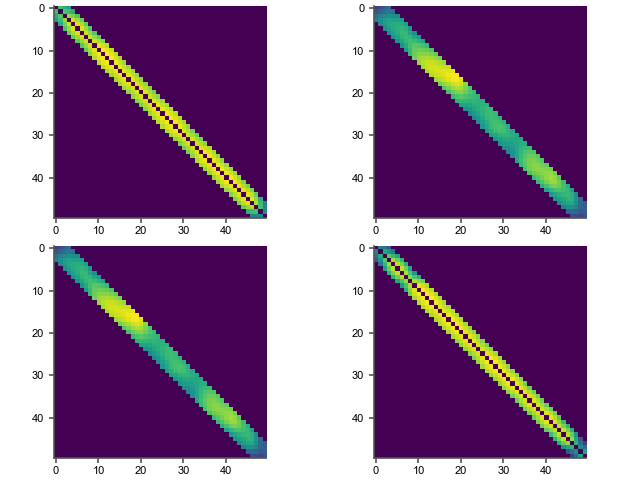

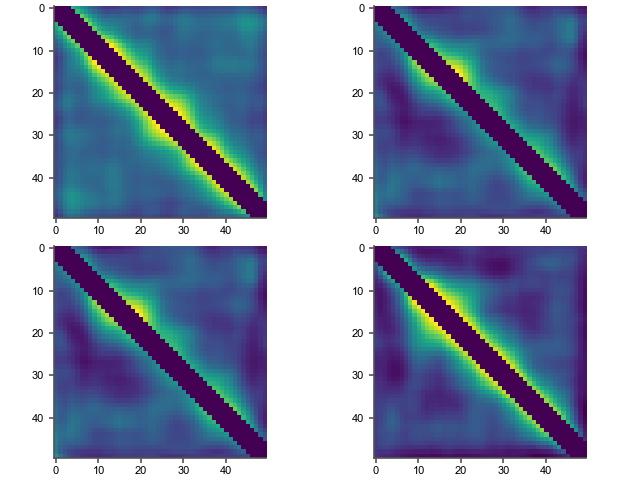

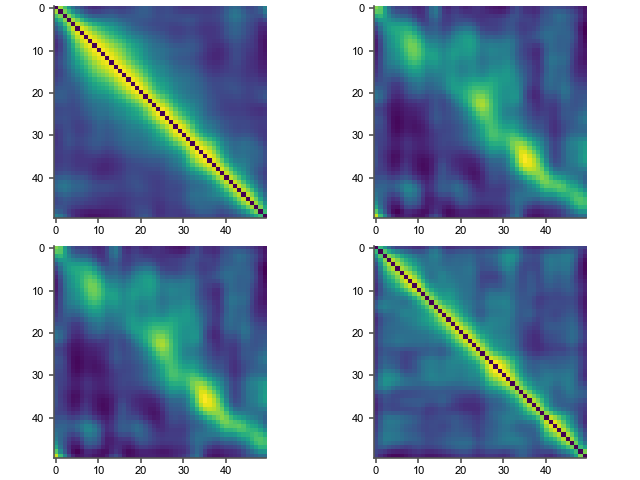

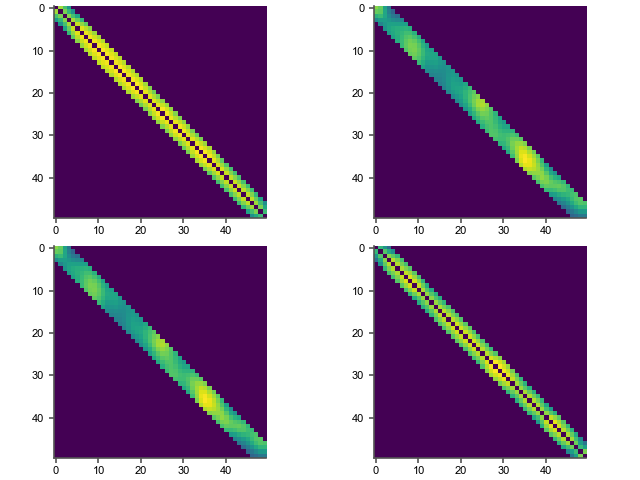

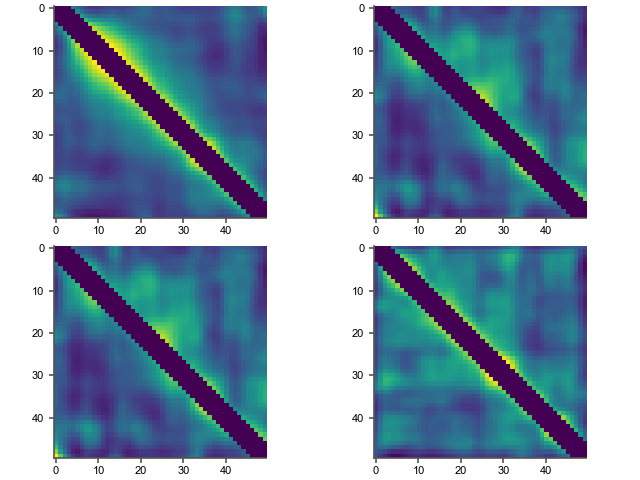

In [105]:
# Another sanity check with the real data
for grp, corr in zip(["NSD", "SD"], corr_all):

    maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    noffset = 3
    
    _, ax = plt.subplots(2, 2)
    for a, corr_use in zip(ax.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        a.imshow(corr_use)
    
    _, axd = plt.subplots(2, 2)
    _, ax = plt.subplots(2, 2)
    corr_off, corr_diag = [], []
    for a, ad, corr_use in zip(ax.reshape(-1), axd.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        # c_trim = np.triu(corr_use, noffset)
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)
        a.imshow(c_off)
        ad.imshow(c_diag)
        # corr_off.append(c_trim[c_trim != 0])
        corr_off.append(np.mean(c_off[c_off != 0]))
        # cdiag = np.diagonal(np.triu(corr_use), offset=noffset - 1)
        corr_diag.append(np.mean(c_diag[c_diag != 0]))
        
    print(f'{grp} Off diagonal corrs = {corr_off}')
    print(f'{grp} On diagonal corrs = {corr_diag}')

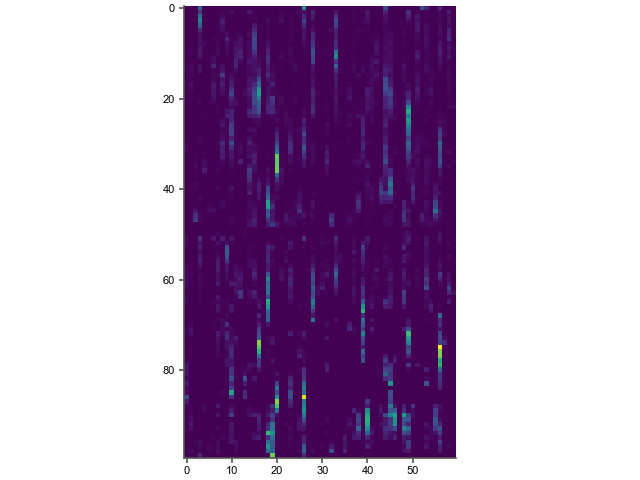

In [215]:
_, ax = plt.subplots()
ax.imshow(tc_sess.T)

In [227]:
tc_sess.shape

(60, 100)

In [231]:
np.corrcoef(tc_sess[~np.all(tc_sess == 0, axis=1)].T)

array([[ 1.        ,  0.38208642,  0.55248083, ...,  0.25824095,
         0.32991484,  0.14872552],
       [ 0.38208642,  1.        ,  0.77336644, ...,  0.0872131 ,
        -0.01775561,  0.03858084],
       [ 0.55248083,  0.77336644,  1.        , ...,  0.10154322,
         0.05622687,  0.13375335],
       ...,
       [ 0.25824095,  0.0872131 ,  0.10154322, ...,  1.        ,
         0.89298727,  0.42846631],
       [ 0.32991484, -0.01775561,  0.05622687, ...,  0.89298727,
         1.        ,  0.52571898],
       [ 0.14872552,  0.03858084,  0.13375335, ...,  0.42846631,
         0.52571898,  1.        ]])

In [211]:
np.corrcoef(tc_sess.T)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1.        ,  0.38485103,  0.55410414, ...,  0.26091528,
         0.33235749,  0.15014139],
       [ 0.38485103,  1.        ,  0.774634  , ...,  0.092716  ,
        -0.01148878,  0.04124879],
       [ 0.55410414,  0.774634  ,  1.        , ...,  0.10575991,
         0.06072924,  0.13556502],
       ...,
       [ 0.26091528,  0.092716  ,  0.10575991, ...,  1.        ,
         0.89347754,  0.42940546],
       [ 0.33235749, -0.01148878,  0.06072924, ...,  0.89347754,
         1.        ,  0.5263856 ],
       [ 0.15014139,  0.04124879,  0.13556502, ...,  0.42940546,
         0.5263856 ,  1.        ]])

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

,MAZE_diag,MAZE_off,reMAZE_diag,reMAZE_off,MAZE-reMAZE_diag,MAZE-reMAZE_off,grp,session
0,0.824102,0.281968,0.774328,0.203081,0.460320,0.156961,NSD,0
1,0.861476,0.633023,0.865396,0.440865,0.481378,0.352381,NSD,1
2,0.861381,0.480103,0.763795,0.229797,0.357282,0.287707,NSD,2
3,0.699895,0.160972,0.663021,0.096180,0.393408,0.101378,SD,3
4,0.923827,0.516235,0.763501,0.551093,0.235501,0.182193,SD,4
5,0.804448,0.290883,0.588032,0.148921,0.385526,0.188537,SD,5
6,0.846183,0.444689,0.837812,0.390073,0.619422,0.351546,SD,6
7,0.747886,0.137848,0.691718,0.134435,0.367425,0.108297,SD,7


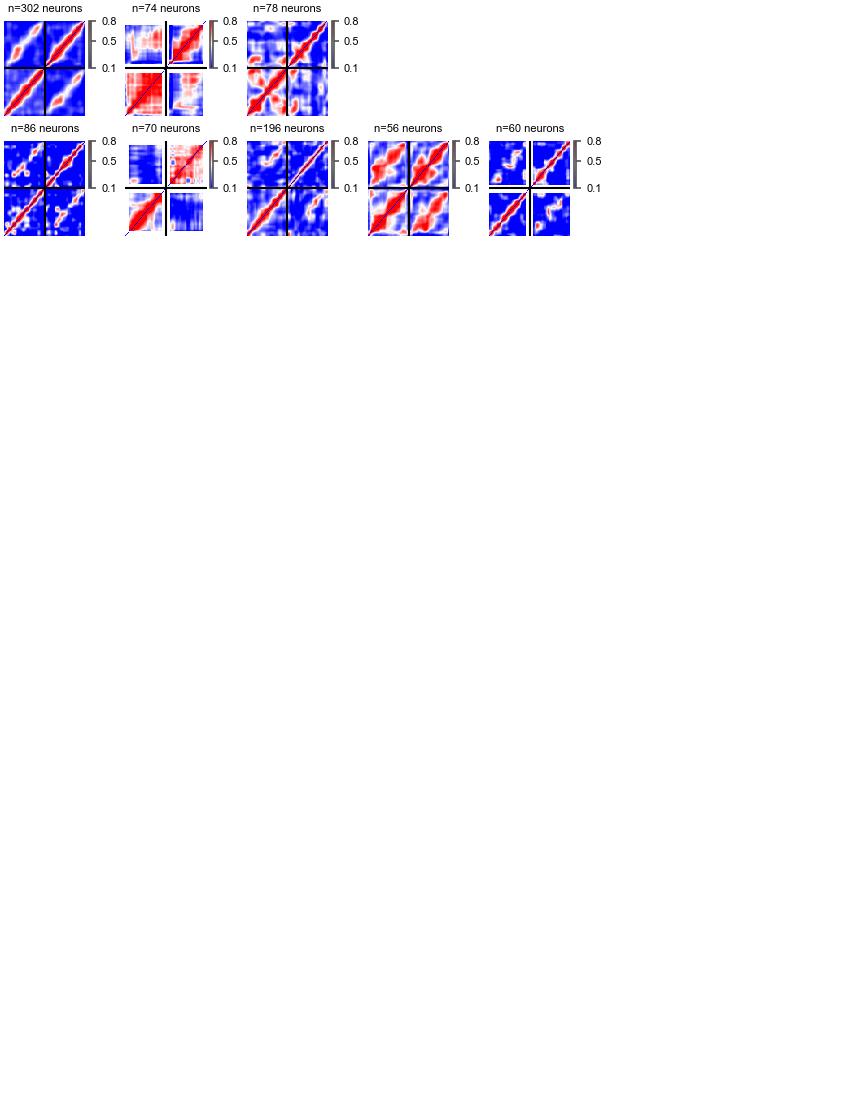

In [579]:
# Calculate PV corr by session
fig = plotting.Fig(11, 8)
noffset = 3

pv_corr_df_sesh = []
idn = 0
for g, grp in enumerate(["NSD", "SD"]):
    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp]
    for ids, sess in enumerate(tc_grp.session.unique()):
        tc_sess = tc_grp[tc_grp.session == sess].drop(columns=["grp", "session"]).to_numpy()
    
        ax = fig.subplot(fig.gs[g, ids])
        corr = gaussian_filter(np.corrcoef(tc_sess.T), 1)
        # corr = np.corrcoef(tc_sess.T)
        ax.set_title(f"n={tc_sess.shape[0]} neurons")
        np.fill_diagonal(corr, 0)
        corr_all.append(corr)
        corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
        ax.axvline(nbins_per_sesh, color="k")
        ax.axhline(nbins_per_sesh, color="k")
        ax.axis("off")
        corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

        maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
        remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
        maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        corr_all, fname = [], []
        for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
            c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
            c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

            # Calculate mean value on diagonal
            corr_all.append(np.nanmean(c_diag[c_diag != 0]))
            fname.append(f"{corr_name}_diag")

            # Calculate mean value on off-diagonal
            corr_all.append(np.nanmean(c_off[c_off != 0]))
            fname.append(f"{corr_name}_off")

        # # Add in grp and session
        # fname.append(grp)
        # fname.append(sess)

        # Make into one dataframe
        # pv_sesh = pd.DataFrame(data=corr_all, columns=fname)
        pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
        pv_sesh["grp"] = grp
        pv_sesh["session"] = sess
        pv_corr_df_sesh.append(pv_sesh)
        idn += 1
            
pv_corr_df_sesh = pd.concat(pv_corr_df_sesh, axis=0)
pv_corr_df_sesh

In [592]:
tc_temp = tc_grp.drop(columns=["grp", "session"]).to_numpy()
PVmaze = tc_temp[:, 0:nbins_per_sesh]
PVreMAZE = tc_temp[:, nbins_per_sesh:]
np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))

array([[1.       , 0.4378789],
       [0.4378789, 1.       ]])

In [596]:
def calc_PV_corr(pf_df_in, filter_std=0, noffset=3):
    """Calculates PV correlations for MAZE, reMAZE, and MAZE-reMAZE. Input is an nneurons x (nspatialbins * 2) dataframe
    with the last two columns denoting the group and recording session. The first nspatialbins contain the mean firing rate for each
    neuron in that direction during MAZE, while the second nspatialbins are the same but for reMAZE"""

    # Make into numpy array
    pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # running they legimately aren't active then but are active at other (non-running) times.
    # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this

    # Also calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
    PVmaze = pf_array[:, 0:nbins_per_sesh]
    PVreMAZE = pf_array[:, nbins_per_sesh:]
    PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]

    # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
    bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
    bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
    bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
    pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
    
    # Calc PV corrs across all spatial bins separately and filter
    PVcorr = np.corrcoef(pf_array.T)
    if filter_std > 0:
        PVcorr = gaussian_filter(PVcorr, filter_std)

    # Segregate PVcorr array
    assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found after removing all-zero bins"
    maze_corr = PVcorr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = PVcorr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    
    # Calculate on-diagonal and off-diagonal mean corrs
    corr_all, fname = [], []
    for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE_reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

        # Calculate mean value on diagonal
        corr_all.append(np.nanmean(c_diag[c_diag != 0]))
        fname.append(f"{corr_name}_diag")

        # Calculate mean value on off-diagonal
        corr_all.append(np.nanmean(c_off[c_off != 0]))
        fname.append(f"{corr_name}_off")

    # Make into one dataframe
    pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
    pv_sesh["PVcorr_maze_remaze"] = PVcorr_maze_remaze
    pv_sesh["grp"] = pf_df_in.reset_index().loc[0, "grp"]
    # pv_sesh["session"] = pf_df_in.loc[0, "session"]

    return pv_sesh

calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, 2)    

,MAZE_diag,MAZE_off,reMAZE_diag,reMAZE_off,MAZE_reMAZE_diag,MAZE_reMAZE_off,PVcorr_maze_remaze,grp
8,0.854438,0.314083,0.743637,0.292268,0.406696,0.201065,0.437879,SD


In [573]:
bootstrap_resample(tc_all, 10, apply=calc_PV_corr, noffset=10)

Running bootstraps for NSD group


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 222.95it/s]


Running bootstraps for SD group


100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 167.86it/s]


,MAZE_diag,MAZE_off,reMAZE_diag,reMAZE_off,MAZE-reMAZE_diag,MAZE-reMAZE_off,grp
0,0.629654,0.235792,0.571584,0.154648,0.352737,0.145316,NSD
1,0.708906,0.464717,0.586703,0.241141,0.351719,0.265764,NSD
2,0.643078,0.296352,0.540563,0.153766,0.359101,0.174304,NSD
3,0.617912,0.226242,0.528662,0.109178,0.344695,0.118114,NSD
4,0.636568,0.259753,0.554241,0.142322,0.383454,0.154875,NSD
5,0.651246,0.277704,0.561423,0.117687,0.323192,0.110067,NSD
6,0.633232,0.221614,0.531416,0.093012,0.354371,0.117772,NSD
7,0.625722,0.219942,0.533865,0.106221,0.354258,0.093933,NSD
8,0.687903,0.440132,0.565807,0.169137,0.345606,0.248412,NSD
9,0.660561,0.293807,0.561488,0.157129,0.389362,0.161151,NSD


In [597]:
# Bootstrap each group and corr
from stats_utils import bootstrap_resample
PVcorrs_bs = bootstrap_resample(tc_all, 1000, apply=calc_PV_corr, noffset=3)
PVcorrs_bs

Running bootstraps for NSD group


100%|█████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.39it/s]


Running bootstraps for SD group


100%|█████████████████████████████████████████| 1000/1000 [00:05<00:00, 167.37it/s]


,MAZE_diag,MAZE_off,reMAZE_diag,reMAZE_off,MAZE_reMAZE_diag,MAZE_reMAZE_off,PVcorr_maze_remaze,grp
0,0.851379,0.337698,0.810181,0.174498,0.421720,0.140133,0.450675,NSD
1,0.861806,0.292216,0.821953,0.224619,0.509931,0.189067,0.566065,NSD
2,0.868250,0.480447,0.803871,0.265939,0.381436,0.245915,0.411663,NSD
3,0.865498,0.294012,0.822240,0.216333,0.460400,0.171418,0.516510,NSD
4,0.857924,0.248245,0.806774,0.175326,0.476249,0.145970,0.519725,NSD
...,...,...,...,...,...,...,...,...
1995,0.851555,0.391454,0.840612,0.373643,0.607116,0.335428,0.635512,SD
1996,0.828911,0.247186,0.700560,0.249340,0.375403,0.153072,0.417131,SD
1997,0.842352,0.336346,0.826551,0.318594,0.565559,0.277338,0.599359,SD
1998,0.871068,0.349006,0.712856,0.296531,0.369398,0.200037,0.384822,SD


In [600]:
# Add in other fields
PVcorrs_bs["MAZE-reMAZE(diag)"] = PVcorrs_bs["MAZE_diag"] - PVcorrs_bs["reMAZE_diag"]
PVcorrs_bs["MAZE-reMAZE(off)"] = PVcorrs_bs["MAZE_off"] - PVcorrs_bs["reMAZE_off"]
PVcorrs_bs["MAZE_diff"] = PVcorrs_bs["MAZE_diag"] - PVcorrs_bs["MAZE_off"]
PVcorrs_bs["reMAZE_diff"] = PVcorrs_bs["reMAZE_diag"] - PVcorrs_bs["reMAZE_off"]

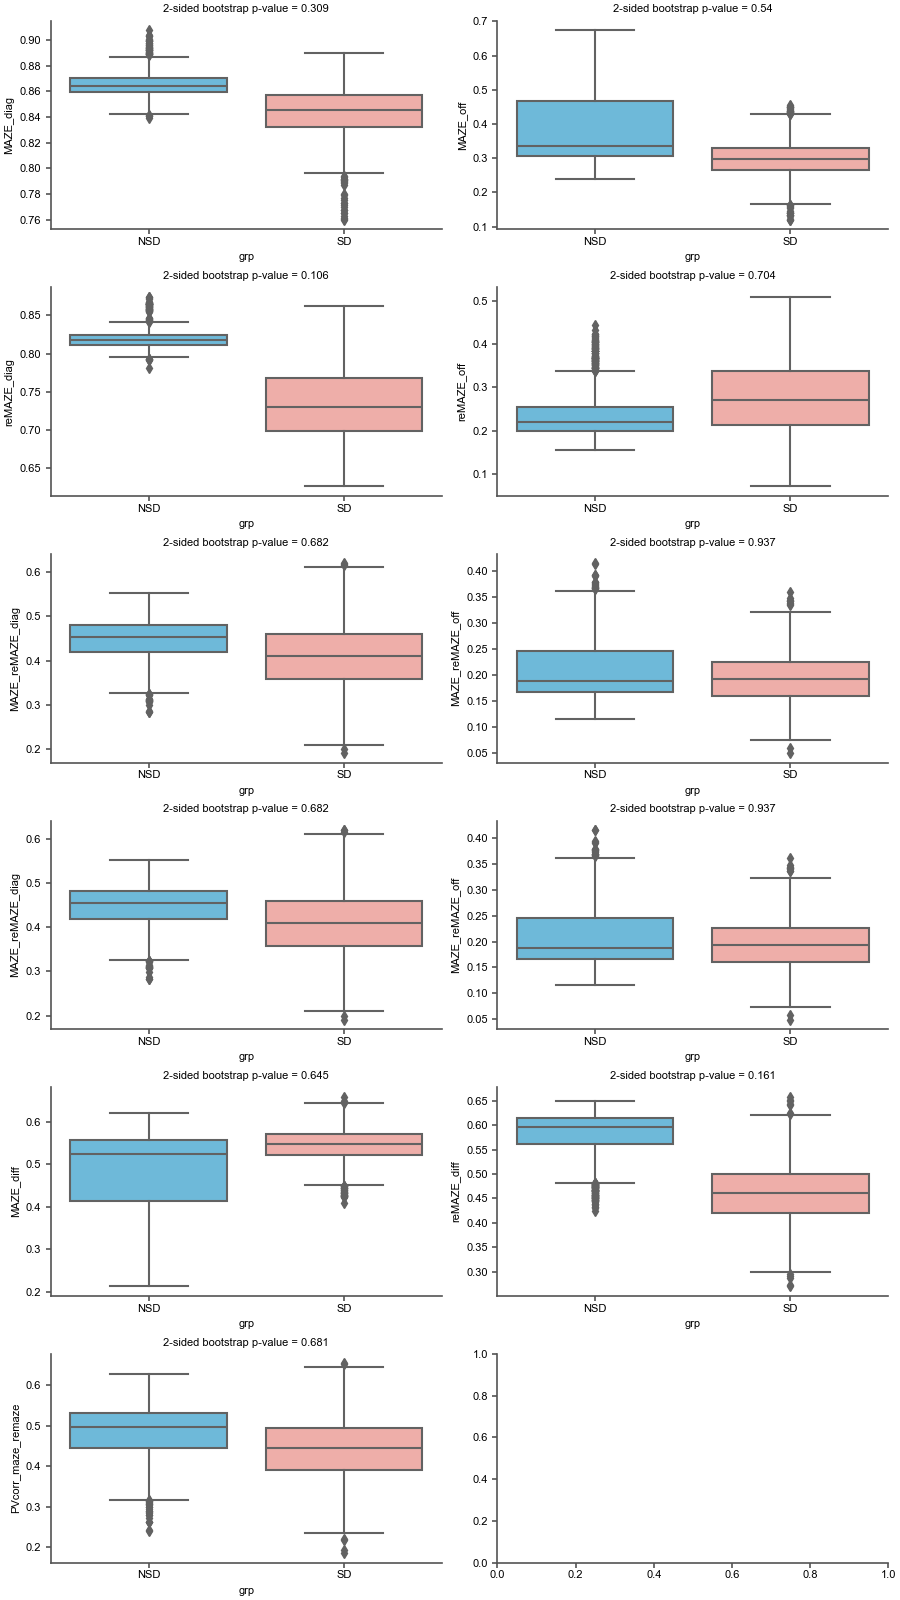

In [601]:
# Visualize
from stats_utils import get_bootstrap_prob
_, ax = plt.subplots(6, 2, figsize=(9, 16))
for a, comp in zip(ax.reshape(-1), ["MAZE_diag", "MAZE_off", "reMAZE_diag",	"reMAZE_off", "MAZE_reMAZE_diag", "MAZE_reMAZE_off",
                                    "MAZE_reMAZE_diag", "MAZE_reMAZE_off", "MAZE_diff", "reMAZE_diff", "PVcorr_maze_remaze"]):
    sns.boxplot(data=PVcorrs_bs, x="grp", y=comp, ax=a)
    stat, pval = get_bootstrap_prob(PVcorrs_bs.loc[PVcorrs_bs.grp == "NSD", comp], PVcorrs_bs.loc[PVcorrs_bs.grp == "SD", comp])
    a.set_title(f"2-sided bootstrap p-value = {2*pval:0.3g}")

# To add:
1) ability to vary noffset bins in bootstrap resampling
2) ability to change smoothing in bootstrap resampling

#### Quantify PF Correlations

In [55]:
def pf_corr_maze_remaze(row, nbins_each_sesh=50):
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]

    return np.corrcoef([maze_tc, remaze_tc])[0, 1]

In [56]:
# Calculate PF correlations
from copy import deepcopy
corrs = []
# for row in tc_all.drop(columns=["session", "grp"]).iterrows():
for row in pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).iterrows():
    corrs.append(pf_corr_maze_remaze(row[1]))
tc_new_df = deepcopy(pd.concat(tc_new_all, axis=0).reset_index())
tc_new_df["PF Corr"] = corrs
tc_new_df["comp"] = 1

<Axes: xlabel='PF Corr', ylabel='Proportion'>

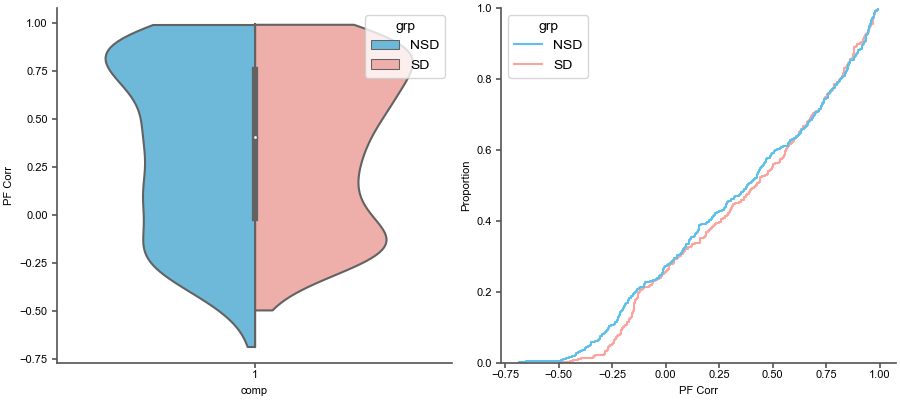

In [57]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.violinplot(data=tc_new_df, x="comp", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
sns.ecdfplot(data=tc_new_df, x="PF Corr", hue="grp", ax=ax[1])

### Plot PF Correlations by position on track

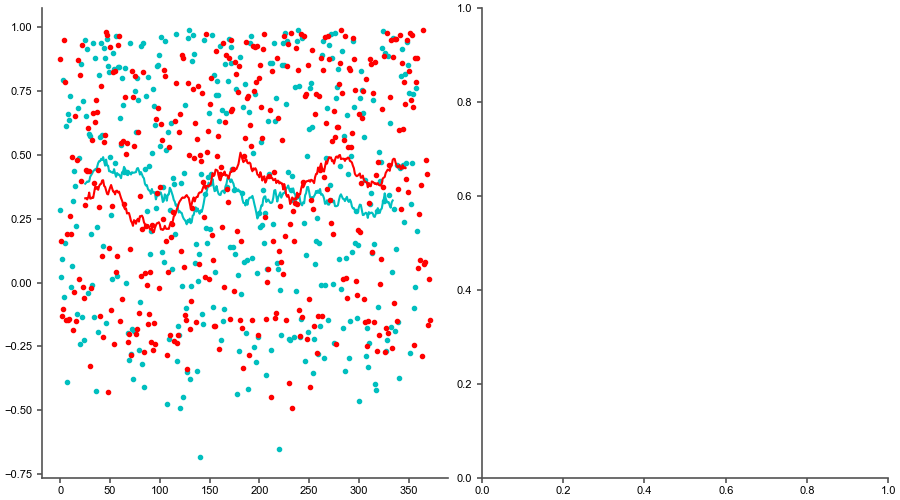

In [52]:
_, ax = plt.subplots(1, 2, figsize=(9, 5))
window = 50
for col, grp in zip(["c", "r"], ["NSD", "SD"]):
    corrs = tc_new_df[tc_new_df.grp == grp]["PF Corr"]
    ax[0].plot(corrs[~np.isnan(corrs)].values, '.', color=col)
    ax[0].plot(corrs[~np.isnan(corrs)].rolling(window, center=True).mean().values, color=col)

# sns.ecdfplot(data=tc_new_df, x="index", y="PF Corr", ax=ax[1], hue="grp")